In [1]:
suppressPackageStartupMessages({
    suppressWarnings({
        library(Seurat, quietly = T)
        library(openxlsx, quietly = T)
        library(ggpubr, quietly = T)
        library(plyr, quietly = T)
        library(dplyr, quietly = T)
        library(textshape)
        library(tidyr)
        library(stringr)
        library(RColorBrewer, quietly = T)

    })
})

In [2]:
server = 'mando'
if (server == 'jabba'){
    data_path = '/data3/hratch/norcross_abc/'
}else if (server == 'mando'){
    data_path = '/data/hratch/norcross_abc/'
}

In [3]:
abc.integrated<-readRDS(paste0(data_path, 'processed/abc_annotated.RDS'))

Since we are testing differences in the same cell type across contexts, we employ DE tests that can control for technical effects. Latent variables that account for technical effects have been [shown](https://www.biorxiv.org/content/10.1101/2022.03.15.484475v1) to be effective for DE across contexts. We will use MAST and the CDR (cellular detection rate) which has been [shown](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-015-0844-5) to be an effective latent variable for technical effects

# CDR

First, we calculate the CDR from the LogNormalized expression matrix:



In [4]:
freq<-function(expr){
    nonzero.counts<-rowSums(expr !=0 ) # get # of nonzero cells per gene
    return(nonzero.counts/dim(expr)[[2]])
}

expr = abc.integrated@assays$RNA@data # log-normalized matrix
expr<-expr[which(freq(expr)>0),] # remove invariant genes

In [5]:
thresh = 0 # calculate CDR on non-zero frequency (NOTE: code will need to be changed if setting higher thresh)
if (thresh == 0){
    cdr<-unlist(unname(scale(colSums(expr!=thresh))[, 1])) # calculate CDR as in MAST tutorial (https://www.bioconductor.org/packages/release/bioc/vignettes/MAST/inst/doc/MAITAnalysis.html)
    cdr.2<-unlist(unname(colSums(expr > thresh)/dim(expr)[[1]])) # calculate as in MAST manuscript
}else{
    stop('Need to implement this if using')
}

Note, although the two methods to calculate the CDR give different absolute values, they have perfect correlation (we will proceed with the tutorial recommended CDR calculation):

In [6]:
identical(cdr, cdr.2)
cor(cdr, cdr.2,  method = "spearman", use = "complete.obs")

[1] FALSE

[1] 1

In [7]:
abc.integrated@meta.data[['cellular.detection.rate']]<-cdr # add cdr to object

# RUN MAST DE

## Part 1: Run to compare a single cell type across contexts

Specifiy the cell types and context comparisons to test for:

In [137]:
cell.types.l1<-setdiff(levels(abc.integrated$Cell.Type.Level1), 'Unknown')

# t cell subsets
md<-abc.integrated@meta.data
cell.types.l2<-levels(droplevels((md[md$Cell.Type.Level1 == 'T-cells', ][['Cell.Type.Level2']])))

comparisons<-list(c('ABC', 'UNTR'),  # second entry is baseline
                  c('DT_ABC', 'DT_Veh'), 
                  c('DT_ABC', 'ABC'))

In [112]:
# compare a cell type between contexts
MAST.de.context<-function(cell.type, context.treat, context.base, 
                          latent.vars, min.pct, lfc.thresh, 
                          cell.level, # 1 or 2
                          so, # seurat object
                          n_samples_thresh = 50 # min # of cells in the comparison
                         ){
#     abc.subset<-subset(x = so, subset = Cell.Type.Level2 == cell.type)
    cl <- FetchData(object = so, vars = paste0('Cell.Type.Level', cell.level))
    abc.subset = so[, which(x = cl == cell.type)]
    
    Idents(abc.subset)<-'orig.ident'
    
#     n_samples<-dim(abc.subset@meta.data[abc.subset@meta.data$orig.ident %in% c(context.treat, context.base),])[[1]]
#     if (n_samples<n_samples_thresh){
#         return (NULL)
    n_samples.treat<-dim(abc.subset@meta.data[abc.subset@meta.data$orig.ident == context.treat,])[[1]]
    n_samples.base<-dim(abc.subset@meta.data[abc.subset@meta.data$orig.ident == context.base,])[[1]]
    if ((n_samples.treat<n_samples_thresh) | (n_samples.base<n_samples_thresh)){
        return (NULL)
    }else{
        suppressWarnings({
            suppressMessages({
                de.res<-FindMarkers(object = abc.subset, 
                                    ident.1 = context.treat, ident.2 = context.base,
                                    assay = 'RNA', only.pos = F, 
                                    slot = 'data', test.use = 'MAST', 
                                    latent.vars = latent.vars,
                                    min.pct = min.pct, 
                                    logfc.threshold = lfc.thresh 
                                                  )
                })
        })

        names(de.res)[names(de.res) == 'p_val_adj'] <- 'bonferroni.adjusted' # rename to specify correction type
        # get the B-H to be less stringent than the native Seurat Bonferroni
        de.res[['BH.adjusted']]<-p.adjust(p = de.res$p_val, method = "BH") 
        de.res[['gene']]<-rownames(de.res)
        de.res[['Cell.Type']]<-cell.type
        de.res[['Cell.Type.Level']]<-cell.level
        de.res[['Comparison']]<-paste0(context.treat, '_vs_', context.base)

        return(de.res) 
    }
}

Filter for cell types with very few cells:

In [4]:
# total_iters = (length(comparisons)*length(cell.types.l1)) + (length(comparisons)*length(cell.types.l2))
# iter<-1
# print('begin de')
# MAST.de.res<-list()
# for (comparison in comparisons){
#     context.treat<-comparison[[1]]
#     context.base<-comparison[[2]]
#     for (ct in cell.types.l1){
#         print(paste0(iter, ' of ', total_iters))
#         cond.name<-paste0(ct, '_', paste0(comparison, collapse = 'vs'))

#         MAST.de.res[[cond.name]]<-MAST.de.context(ct, context.treat, context.base, 
#                                                   latent.vars = 'cellular.detection.rate', 
#                                                   min.pct = 0.1, lfc.thresh = 0.5,
#                                                   cell.level = '1',
#                                                   so = abc.integrated)
#         iter<-iter + 1
#         }
#     for (ct in cell.types.l2){
#         print(paste0(iter, ' of ', total_iters))
#         cond.name<-paste0(ct, '_', paste0(comparison, collapse = 'vs'))

#         MAST.de.res[[cond.name]]<-MAST.de.context(ct, context.treat, context.base, 
#                                                   latent.vars = 'cellular.detection.rate', 
#                                                   min.pct = 0.1, lfc.thresh = 0.5,
#                                                   cell.level = '2',
#                                                   so = abc.integrated)
#         iter<-iter + 1
#     }
# }
# saveRDS(MAST.de.res, paste0(data_path, 'processed/MAST_condition-specific_DE.RDS'))
# print('complete')
MAST.de.res<-readRDS(paste0(data_path, 'processed/MAST_condition-specific_DE.RDS'))

In [5]:
de.res<-do.call("rbind", MAST.de.res)

de.res<-de.res[de.res$BH.adjusted <= 0.1,] # filter on BH
de.res<-de.res[with(de.res, order(Cell.Type, -abs(avg_log2FC), BH.adjusted)), ]

print('# of DE genes after filtering:')
table(de.res$Cell.Type, de.res$Comparison)

[1] "# of DE genes after filtering:"


                
                 ABC_vs_UNTR DT_ABC_vs_ABC DT_ABC_vs_DT_Veh
  CD4+ TE                  0           399              221
  CD4+ Treg              268           309                0
  CD4+TN                  87           151               86
  CD8+ TE/Ex               0             0              274
  CD8+ TEA_1             212           228                0
  CD8+ TEA_2             109           410                0
  CD8+ TEx prec            0           421              247
  CD8+ TN                 89           113               49
  CD8+ TN/EA-ISG          37           225                0
  cDC_1                    0           236              166
  cDC_2                    0           259               63
  gd-T                    17           192              286
  Mf                       0           598              661
  ncMono                   0             0               87
  NK  cells                0           276                0
  pDC                  

In [64]:
counter<-1
metascape_input = list()
metascape_input[['_BACKGROUND']]<-as.matrix(rownames(abc.integrated@assays$RNA@data)) # the universe
context_comparisons_workbook<-createWorkbook()
for (comparison in unique(de.res$Comparison)){
    for (cell.type in  unique(de.res$Cell.Type)){
        de.res.cl<-de.res[(de.res$Comparison == comparison) & (de.res$Cell.Type == cell.type), ]
        if (dim(de.res.cl)[[1]] > 0){
            rownames(de.res.cl)<-1:dim(de.res.cl)[[1]]
            
            res.name<-paste0(gsub('/', '_', cell.type), '_', comparison)
            
            if ((grepl('CD8+', res.name, fixed = TRUE)) | 
                (grepl('CD4+', res.name, fixed = TRUE)) | 
                (grepl('gd-T', res.name, fixed = TRUE))){
                metascape_input[[res.name]]<-de.res.cl$gene
            }
            addWorksheet(context_comparisons_workbook, paste0(counter))
            writeData(context_comparisons_workbook, sheet = paste0(counter), x = de.res.cl)
            counter<-counter+1

            write.csv(de.res.cl, 
                      paste0(data_path, 'processed/', res.name, 'MAST_IPA_input.csv'))
        }
    }
}
saveWorkbook(context_comparisons_workbook, overwrite = T, 
                 paste0(data_path, 'processed/', 'MAST_condition-specific_DE.xlsx'))

# format input to metascape
max.length <- max(sapply(metascape_input, length))
metascape_input <- lapply(metascape_input, function(v) { c(v, rep(NA, max.length-length(v)))})
metascape_input<-do.call(cbind, metascape_input)
write.csv(metascape_input, paste0(data_path, 'interim/', 'metascape_input.csv'), row.names=FALSE)

## Part 2: Run to compare different cell types, independent of context

Based on trajectory analysis, also compare CD8+ TEA_1 w/ CD8+ TEA_2 in the combined DT_ABC/aCD4_ABC conditions. 

In [38]:
# compare between cell types within a given context(s)
MAST.de.celltypes<-function(contexts, cell.type.treat, cell.type.base, latent.vars, min.pct, lfc.thresh, 
                           so = abc.integrated, cell.level = '2'){
    abc.subset<-subset(x = so, subset = orig.ident %in% contexts)
    Idents(abc.subset)<-paste0('Cell.Type.Level', cell.level)
    
    suppressWarnings({
        suppressMessages({
            de.res<-FindMarkers(object = abc.subset, 
                                ident.1 = cell.type.treat, ident.2 = cell.type.base,
                                assay = 'RNA', only.pos = F, 
                                slot = 'data', test.use = 'MAST', 
                                latent.vars = latent.vars,
                                min.pct = min.pct, 
                                logfc.threshold = lfc.thresh 
                                              )
            })
    })
    
    names(de.res)[names(de.res) == 'p_val_adj'] <- 'bonferroni.adjusted' # rename to specify correction type
    # get the B-H to be less stringent than the native Seurat Bonferroni
    de.res[['BH.adjusted']]<-p.adjust(p = de.res$p_val, method = "BH") 
    de.res[['gene']]<-rownames(de.res)
    de.res[['Combined.Contexts']]<-paste0(contexts, collapse=";")
    de.res[['Comparison']]<-paste0(cell.type.treat, '_vs_', cell.type.base)
    
    return(de.res)
}

In [46]:
contexts<-list(c('DT_ABC', 'aCD4_ABC'))
comparisons<-list(c('CD8+ TEA_1', 'CD8+ TEA_2'))

In [47]:
MAST.de.res.ct<-list()
for (comparison in comparisons){
    for (contexts_ in contexts){
        ct.treat<-comparison[[1]]
        ct.base<-comparison[[2]]
        cond.name<-paste0(paste0(contexts, collapse=";"), '_', paste0(comparison, collapse = 'vs'))

        MAST.de.res.ct[[cond.name]]<-MAST.de.celltypes(contexts_, ct.treat, ct.base, 
                                      latent.vars = 'cellular.detection.rate', 
                                         min.pct = 0.1, lfc.thresh = 0.5)
    }
}


In [48]:
de.res.ct<-do.call("rbind", MAST.de.res.ct)
de.res.ct<-de.res.ct[de.res.ct$BH.adjusted <= 0.1,]

print('# of DE genes after filtering:')
table(de.res.ct$Combined.Contexts, de.res.ct$Comparison)

[1] "# of DE genes after filtering:"


                 
                  CD8+ TEA_1_vs_CD8+ TEA_2
  DT_ABC;aCD4_ABC                      429

In [50]:
write.csv(de.res.ct, paste0(data_path, 'processed/', 'CD8TEA_de.csv'))

# Enrichment Analysis

In [ ]:
# universe.features<-as.matrix(rownames(abc.integrated@assays$RNA@data))
# write.csv(universe.features, paste0(data_path, 'interim/', 'enrichment_universe.csv'))

Siva runs gene lists through Metascape, and we visualize the output here:

In [21]:
# top_n = 20 # of terms to visualize

In [32]:
# enrich.level2<-openxlsx::read.xlsx(xlsxFile = paste0(data_path, 'interim/', 'metascape_level2.xlsx'), 
#                                   sheet = 'Enrichment')
# enrich.level2[['Frequency']]<-sapply(enrich.level2$InTerm_InList, function(x) eval(parse(text=x)))
# enrich.level2[['Count']]<-sapply(enrich.level2$InTerm_InList, function(x) as.numeric(stringr::str_split(x, '/')[[1]][[1]]))

# # filter for summary terms                                     
# enrich.level2<-enrich.level2[sapply(enrich.level2$GroupID, function(x) endsWith(x, '_Summary')),]
# enrich.level2<-enrich.level2[1:top_n, ]

# Enrichment Analysis Visualization

## Version 1 - Siva's input:

In [557]:
mo<-openxlsx::read.xlsx(paste0(data_path, 'interim/', 'metascape_out_siva.xlsx'), 
                    sheet = 'Final dotplot data')

In [558]:
pvals<-mo[, c(1, seq(2, dim(mo)[[2]], 2))][-1,]
colnames(pvals)[1]<-'Enrichment.Term'

colnames(pvals)[2:dim(pvals)[[2]]]<-unname(sapply(colnames(pvals)[2:dim(pvals)[[2]]], 
                                                  function(x) gsub("\\+\\.", "+ ", x)))
colnames(pvals)[2:dim(pvals)[[2]]]<-unname(sapply(colnames(pvals)[2:dim(pvals)[[2]]], 
                                                  function(x) gsub("__", "+ ", x)))
colnames(pvals)[2:dim(pvals)[[2]]]<-unname(sapply(colnames(pvals)[2:dim(pvals)[[2]]], 
                                                  function(x) gsub("precDT", "prec_DT", x)))
cond.names<-colnames(pvals)[2:dim(pvals)[[2]]]

freq<-mo[, seq(1, dim(mo)[[2]], 2)][-1,]
colnames(freq)<-colnames(pvals)


pvals<-melt(pvals, id.vars = 'Enrichment.Term', value.name = 'log10p', variable.name = 'Condition')
freq<-melt(freq, id.vars = 'Enrichment.Term', value.name = 'Frequency', variable.name = 'Condition')
pvals[['log10p']] <- -as.numeric(pvals[['log10p']]) 
viz.df <- cbind(pvals, Frequency = as.numeric(freq$Frequency))

Only terms with p_val <= 0.05 visualized:

Warning message:
“Removed 221 rows containing missing values (`geom_point()`).”


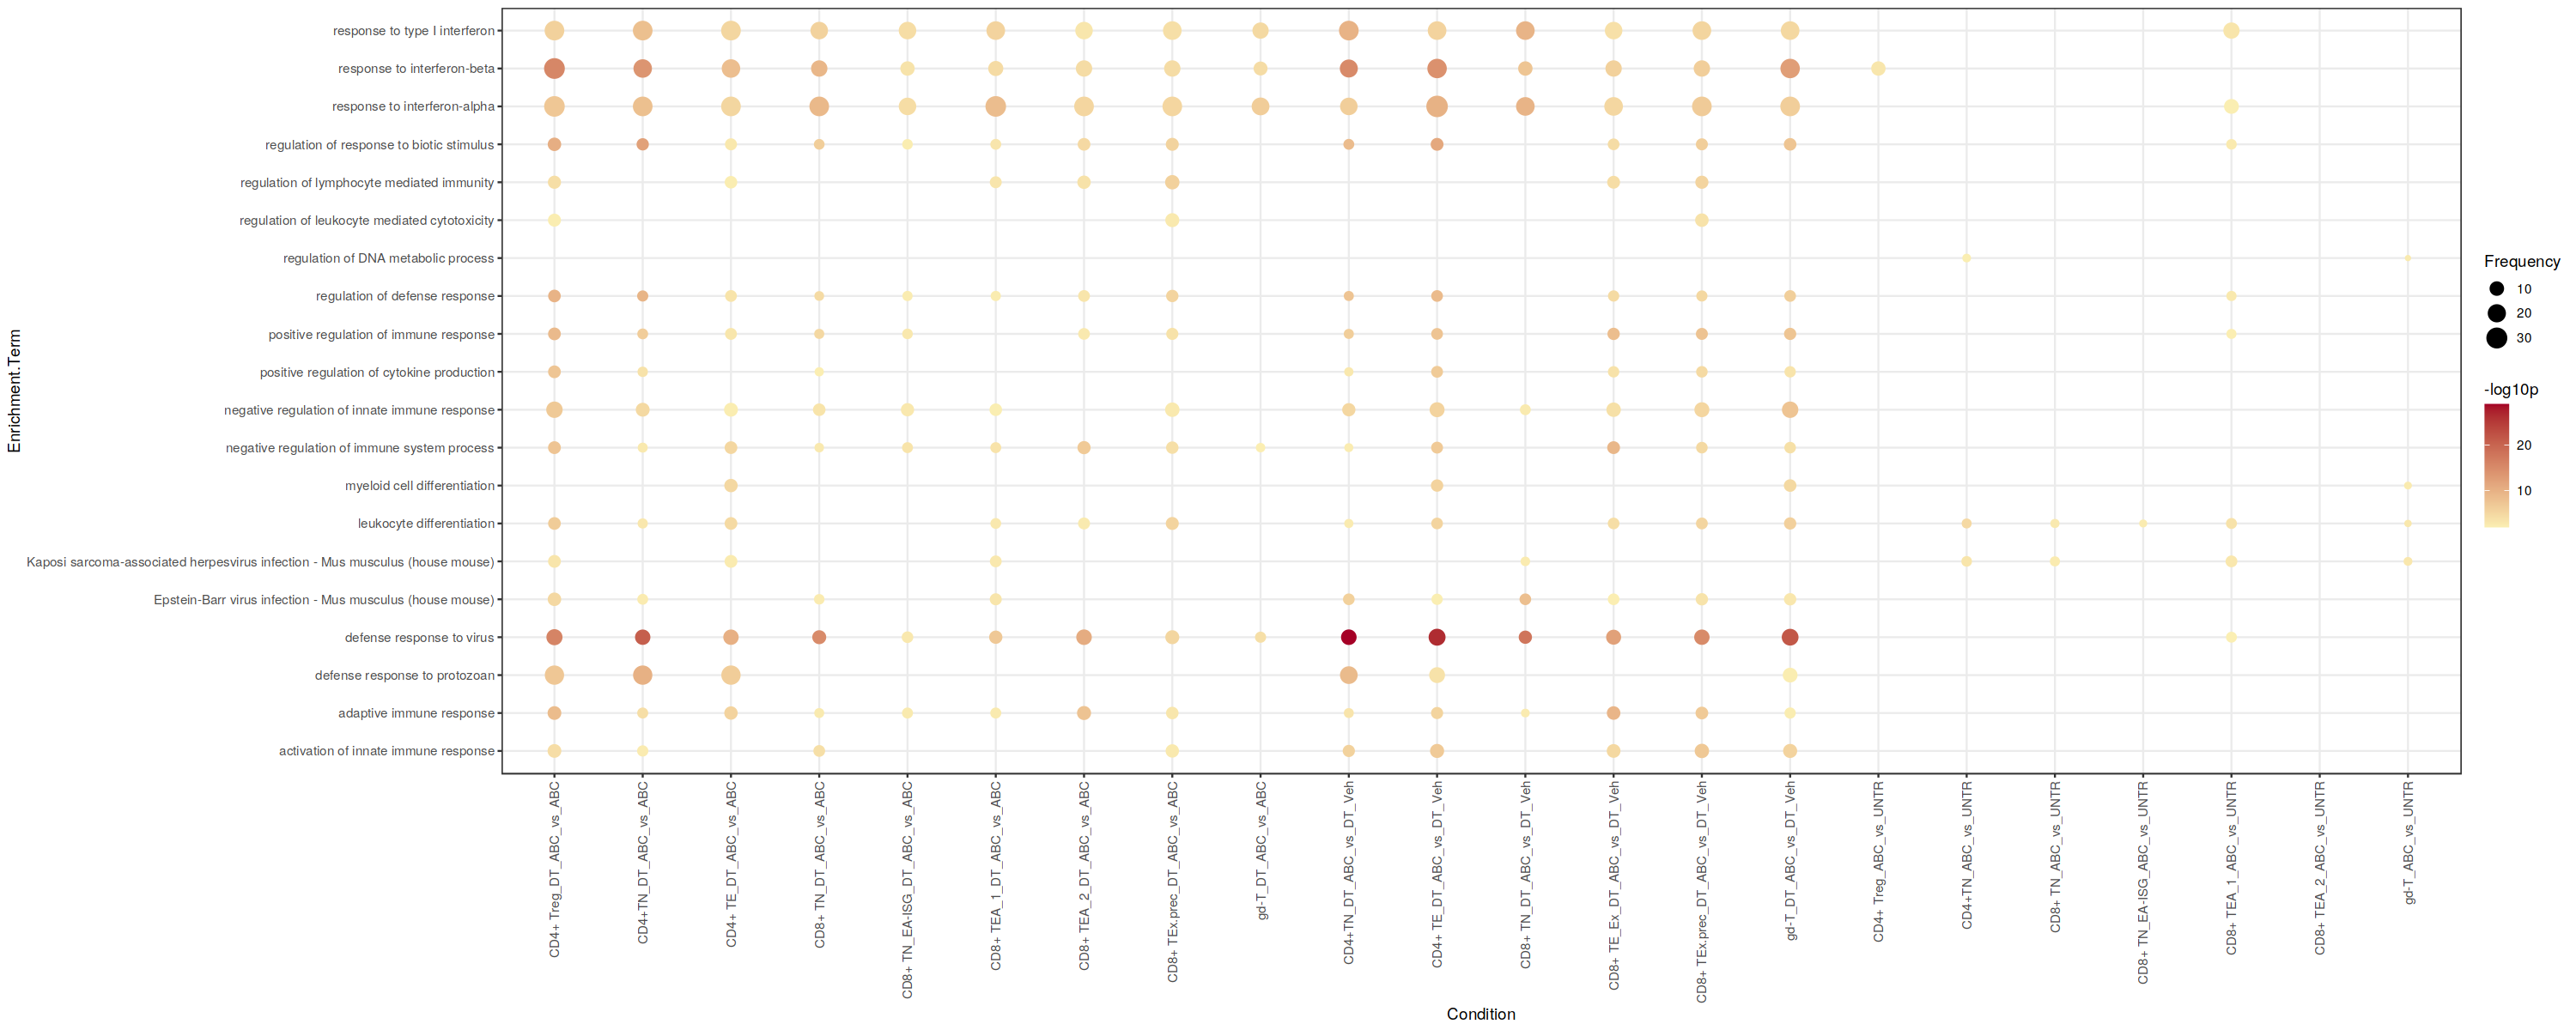

In [559]:
h_ = 10
w_ = 25
options(repr.plot.height=h_, repr.plot.width=w_)

green_hex = brewer.pal(n = 11, name ='RdYlGn')[[11]]
yellow_hex = brewer.pal(n=11, name = 'RdYlBu')[[6]]
red_hex = brewer.pal(n=11, name = 'RdYlBu')[[1]]


ggplot(data = viz.df, aes(x = Condition, y = Enrichment.Term, color = log10p, size = Frequency)) + 
geom_point() + 
scale_color_gradient2(low = green_hex, mid = yellow_hex, high = red_hex, name = '-log10p') + 
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

## Version 2-3: All Lists together with Background Genes

<font color='red'>**Note for Montse and Siva**</font>:

I re-ran metascape on all the comparisons and included the background genes (i.e., all genes that were tested for DE rather than the metascape default of the whole genome). 

Looking at the output, the results for each individual gene list are reported in the file entitled "GO_AllLists.csv" in the "Enrichment_GO" output. The counts are the column "#GeneInGOAndHitList", the frequency is the column "%InGO",  p-values are in the "LogP" column, and multiple test corrected q-values in the "Log(q-value)" column. 

According to the [description](https://metascape.org/gp/index.html#/main/step1), Table 3 in the URL reports one value, which is simply taken from the most significant p-value for a given term across all gene lists. The reason these reported values occasionally do not agree with the values in the "GO_AllLists.csv" is that when running multiple gene lists simultaneously, metascape does an additional step of re-running the enrichment for that term but with all significant gene lists combined into one. If that combined list results in a more significant p-value than each one separately, it reports that in table 3. If this is the case, this can be seen in the "_FINAL_GO.csv" in the same folder. Here, if the  values in the columns "BestLogPInGroup" and "#GeneInGOAndHitList" do not match any of the individual gene lists' values, then the combined list was the reported one. 

Finally, the data to reproduce their unique method for rank ordering the enriched terms (and merge them together), is unavailable in the outputs -- it involves clustering the terms in order to remove redundancy/like-terms. But, fortunately, the first column in the "HeatmapSelectedGo.csv" within the "Enrichment_heatmap" folder lists the terms they ended up ranking as the highest. Those terms are also in the order of the hierarchical clustering, so I just keep them in the same order. I visualized two versions of this: 1) reproduce their heatmap, with the addition of the count frequency for each term, in dotplot format; 2) this same visual, but with q-values instead of p-values and additional filters

I think there are 2 benefits to this approach: A) inputting background genes is more statistically sound, B) I believe that by running all the lists simultaneously, MetaScape rank orders enriched terms in some manner that considers all the lists. 

### Version 2 - original top 20 enriched terms

Load the summary data for the top enriched terms:

In [595]:
ms.top20<-read.csv(paste0(data_path, 'interim/', 'metascape_out/Enrichment_heatmap/HeatmapSelectedGO.csv'))
ms.top100<-read.csv(paste0(data_path, 'interim/', 'metascape_out/Enrichment_heatmap/HeatmapSelectedGOTop100.csv'))

Load the data for each gene list:

First, let's see if there is any duplicate Description/GeneList combinations:

In [596]:
ms %>%
  dplyr::group_by(GeneList, Description) %>%
  dplyr::summarise(n = dplyr::n(), .groups = "drop") %>%
  dplyr::filter(n > 1L)

GeneList,Description,n
<chr>,<chr>,<int>
CD8+ TE_Ex_DT_ABC_vs_DT_Veh,Apoptosis,2


In [597]:
ms[(ms$Description == 'Apoptosis') & (ms$GeneList == 'CD8+ TE_Ex_DT_ABC_vs_DT_Veh'), ]

,Category,CategoryID,GO,Description,PARENT_GO,LogP,Enrichment,Z.score,X.TotalGeneInLibrary,X.GeneInGO,X.GeneInHitList,X.GeneInGOAndHitList,X.InGO,STDV..InGO,GeneID,Hits,Log.q.value.,GeneList
,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
2043,Reactome Gene Sets,6,R-MMU-109581,Apoptosis,,-2.8,4.0,4.1,14653,99,256,7,2.7,1.00,14102|14939|14958|16905|20230|22035|66593,Fas|Gzmb|H1f0|Lmna|Satb1|Tnfsf10|Diablo,-1.7,CD8+ TE_Ex_DT_ABC_vs_DT_Veh
2055,WikiPathways,27,WP1254,Apoptosis,,-2.7,4.5,4.1,14653,76,256,6,2.3,0.95,12362|14102|16992|22035|54123|66593,Casp1|Fas|Lta|Tnfsf10|Irf7|Diablo,-1.7,CD8+ TE_Ex_DT_ABC_vs_DT_Veh


In [598]:
'Apoptosis' %in% ms.top100$Description

[1] FALSE

Looks like there is one term that is repeated twice, Apoptosis. However, this term is not in our top enriched terms, so it won't effect things. Furthermore, output values are quite similar. So, we aggregate by the average in this case. 

In [607]:
format.ms<-function(val_col){
    val_df<-as.data.frame(pivot_wider(data = ms, id_cols = 'GeneList', names_from = 'Description', 
                                      values_from = val_col, 
                                    values_fn = mean))
    val_df<-t(column_to_rownames(x = val_df, loc = 1))
    colnames(val_df)<-unname(sapply(colnames(val_df), function(x) gsub("TEx prec", "TEx.prec", x)))
    if (length((setdiff(colnames(val_df), cond.names)))>1){
        stop('Unexpected differnt conditions')
    }
    val_df<-val_df[, cond.names]
    return(val_df)
}

In [608]:
pvals<-ms.top20[, colnames(ms.top20) != 'GO']
colnames(pvals)[[1]]<-'Enrichment.Term'
pvals<-column_to_rownames(x = pvals, loc = 1)
# format column names to match that of siva's input (cond.names)
colnames(pvals) <- unname(sapply(colnames(pvals),function(x) stringr::str_split(x, 'X_LogP_')[[1]][[2]]))
colnames(pvals)<-unname(sapply(colnames(pvals), function(x) gsub("\\.\\.", "+ ", x)))
colnames(pvals)<-unname(sapply(colnames(pvals), function(x) gsub("4\\.", "4+", x)))
colnames(pvals)<-unname(sapply(colnames(pvals), function(x) gsub("gd.T", "gd-T", x)))
colnames(pvals)<-unname(sapply(colnames(pvals), function(x) gsub("EA.ISG", "EA-ISG", x)))
colnames(pvals)<-unname(sapply(colnames(pvals), function(x) gsub("precDT", "prec_DT", x)))
if (length((setdiff(colnames(pvals), cond.names)))>1){
    stop('Unexpected differnt conditions')
}
pvals<-pvals[, cond.names]
enriched.terms<-rownames(pvals)                               
                               
freq<-format.ms(val_col = 'X.InGO')    
freq<-freq[enriched.terms, ] # filter for top 20
                               
colnames(freq)<-unname(sapply(colnames(freq), function(x) gsub("TEx prec", "TEx.prec", x)))
if (length((setdiff(colnames(freq), cond.names)))>1){
    stop('Unexpected differnt conditions')
}
freq<-freq[, cond.names]
                              
pvals<-as.data.frame(pvals)
pvals[['Enrichment.Term']]<-rownames(pvals)

freq<-as.data.frame(freq)
freq[['Enrichment.Term']]<-rownames(freq)

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(val_col)

  # Now:
  data %>% select(all_of(val_col))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


In [609]:
pvals<-melt(pvals, id.vars = 'Enrichment.Term', value.name = 'log10p', variable.name = 'Condition')
freq<-melt(freq, id.vars = 'Enrichment.Term', value.name = 'Frequency', variable.name = 'Condition')
pvals[['log10p']] <- -as.numeric(pvals[['log10p']]) 
viz.df <- cbind(pvals, Frequency = as.numeric(freq$Frequency))

Warning message:
“Removed 217 rows containing missing values (`geom_point()`).”


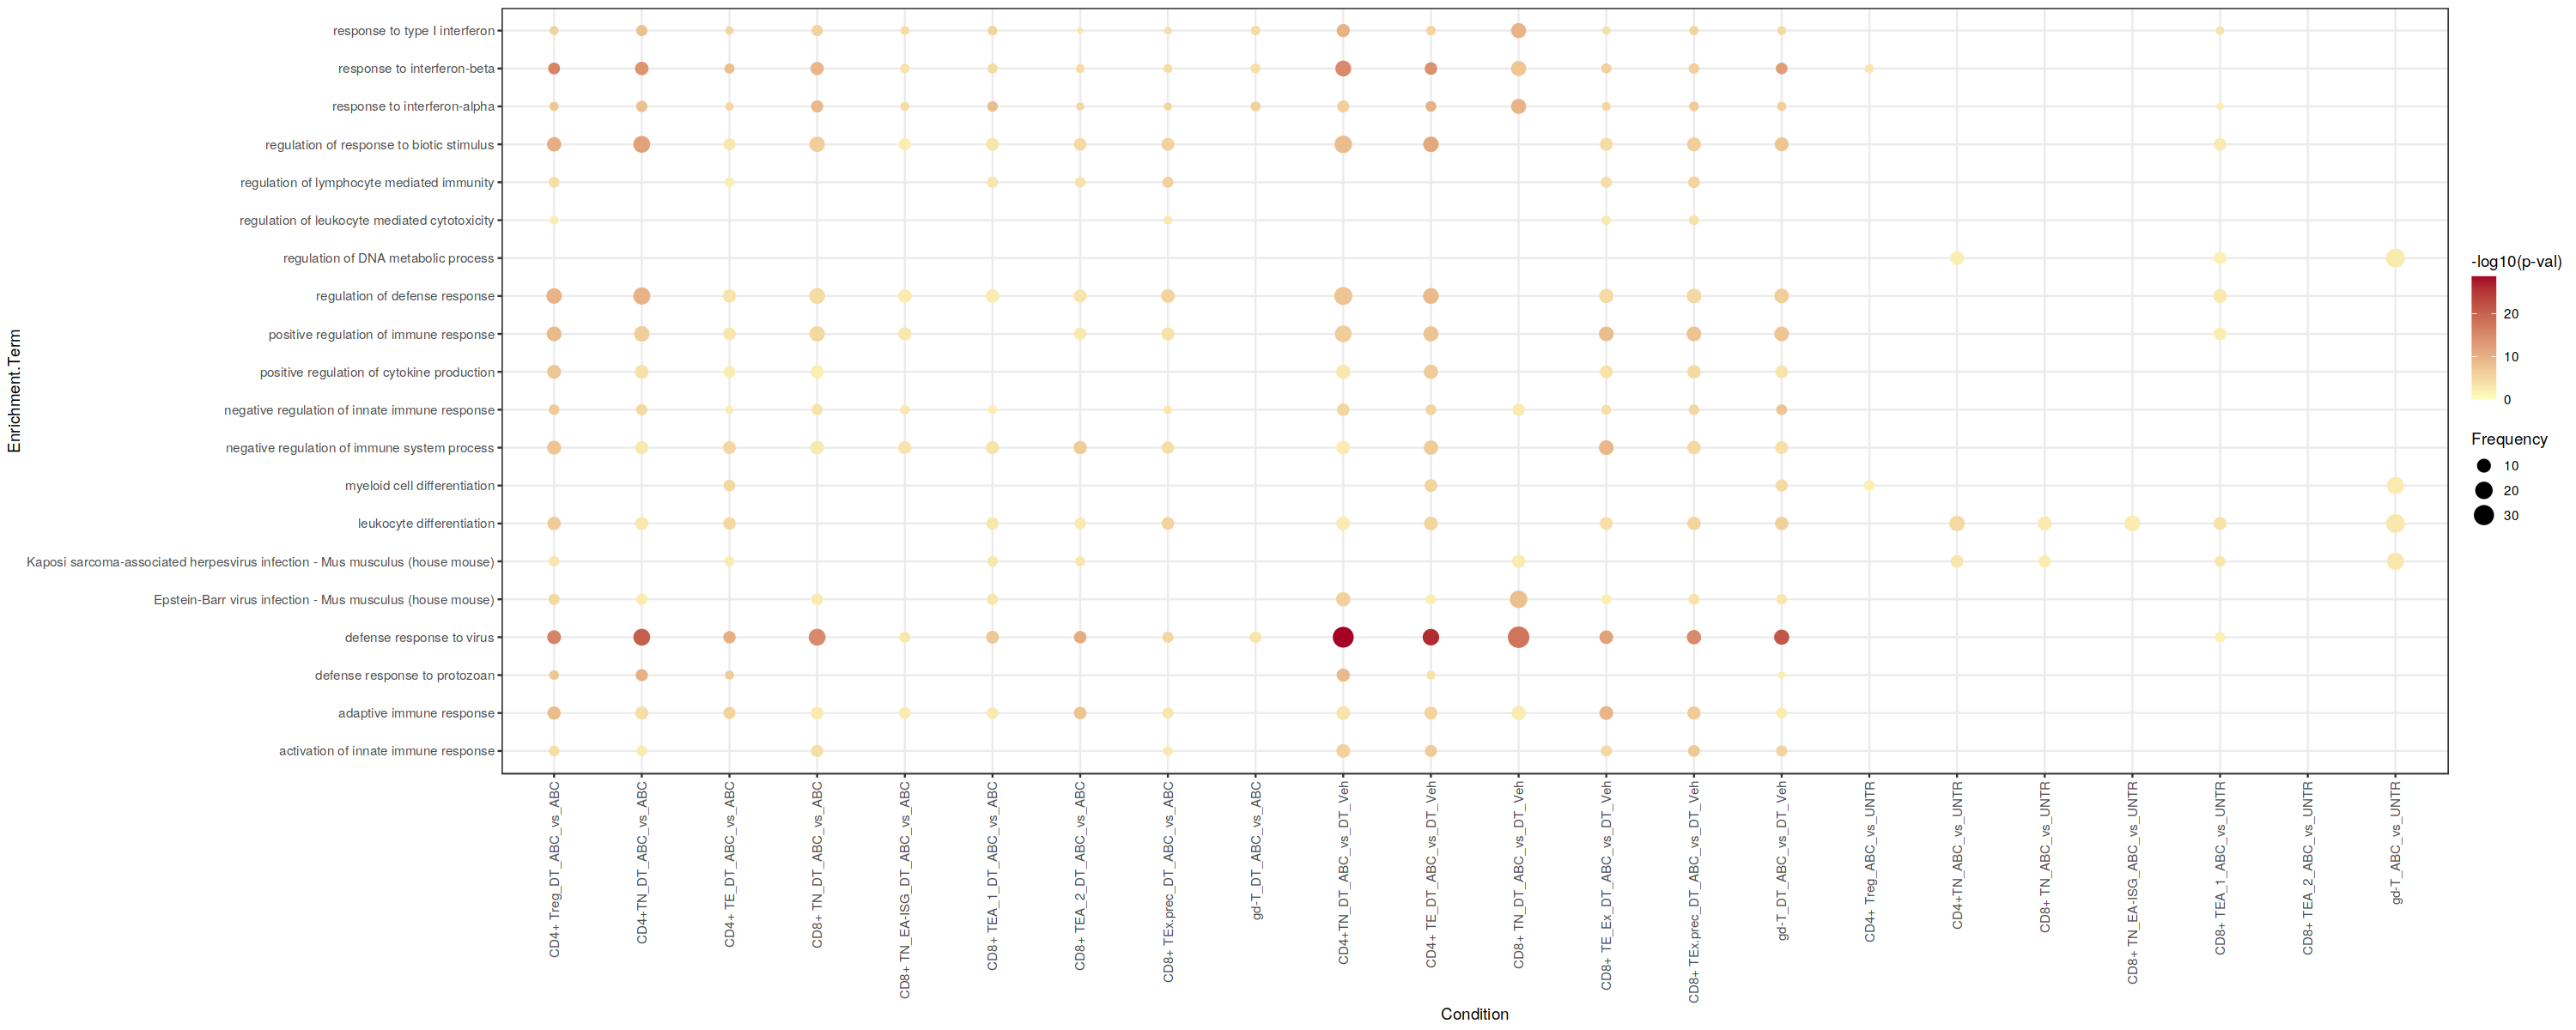

In [611]:
h_ = 10
w_ = 25
options(repr.plot.height=h_, repr.plot.width=w_)

green_hex = brewer.pal(n = 11, name ='RdYlGn')[[11]]
yellow_hex = brewer.pal(n=11, name = 'RdYlBu')[[6]]
red_hex = brewer.pal(n=11, name = 'RdYlBu')[[1]]


ggplot(data = viz.df, aes(x = Condition, y = Enrichment.Term, color = log10p, size = Frequency)) + 
geom_point() + 
scale_color_gradient2(low = green_hex, mid = yellow_hex, high = red_hex, name = '-log10(p-val)') + 
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

## Version 3 - same as Version 2 but with q-vals instead of p-vals

All terms are already q-val > 0.1 and abs(enrichment_score) > 2, so don't need to apply thresholds.
Looks pretty similar, I would go with this one since it's more statistically appropriate

In [645]:
freq<-format.ms(val_col = 'X.InGO')[enriched.terms, ] # filter for top 20
pvals<-format.ms(val_col = 'Log.q.value.')[enriched.terms, ] 


pvals<-as.data.frame(pvals)
pvals[['Enrichment.Term']]<-rownames(pvals)
freq<-as.data.frame(freq)
freq[['Enrichment.Term']]<-rownames(freq)

pvals<-melt(pvals, id.vars = 'Enrichment.Term', value.name = 'log10p', variable.name = 'Condition')
freq<-melt(freq, id.vars = 'Enrichment.Term', value.name = 'Frequency', variable.name = 'Condition')
pvals[['log10p']] <- -as.numeric(pvals[['log10p']]) 

# sig_thresh = 0.1
# inverse_log_q<-sapply(pvals$log10p, function(x) 10^x)
# pvals[inverse_log_q > sig_thresh, 'log10p']<-NA

viz.df <- cbind(pvals, Frequency = as.numeric(freq$Frequency))

Warning message:
“Removed 217 rows containing missing values (`geom_point()`).”


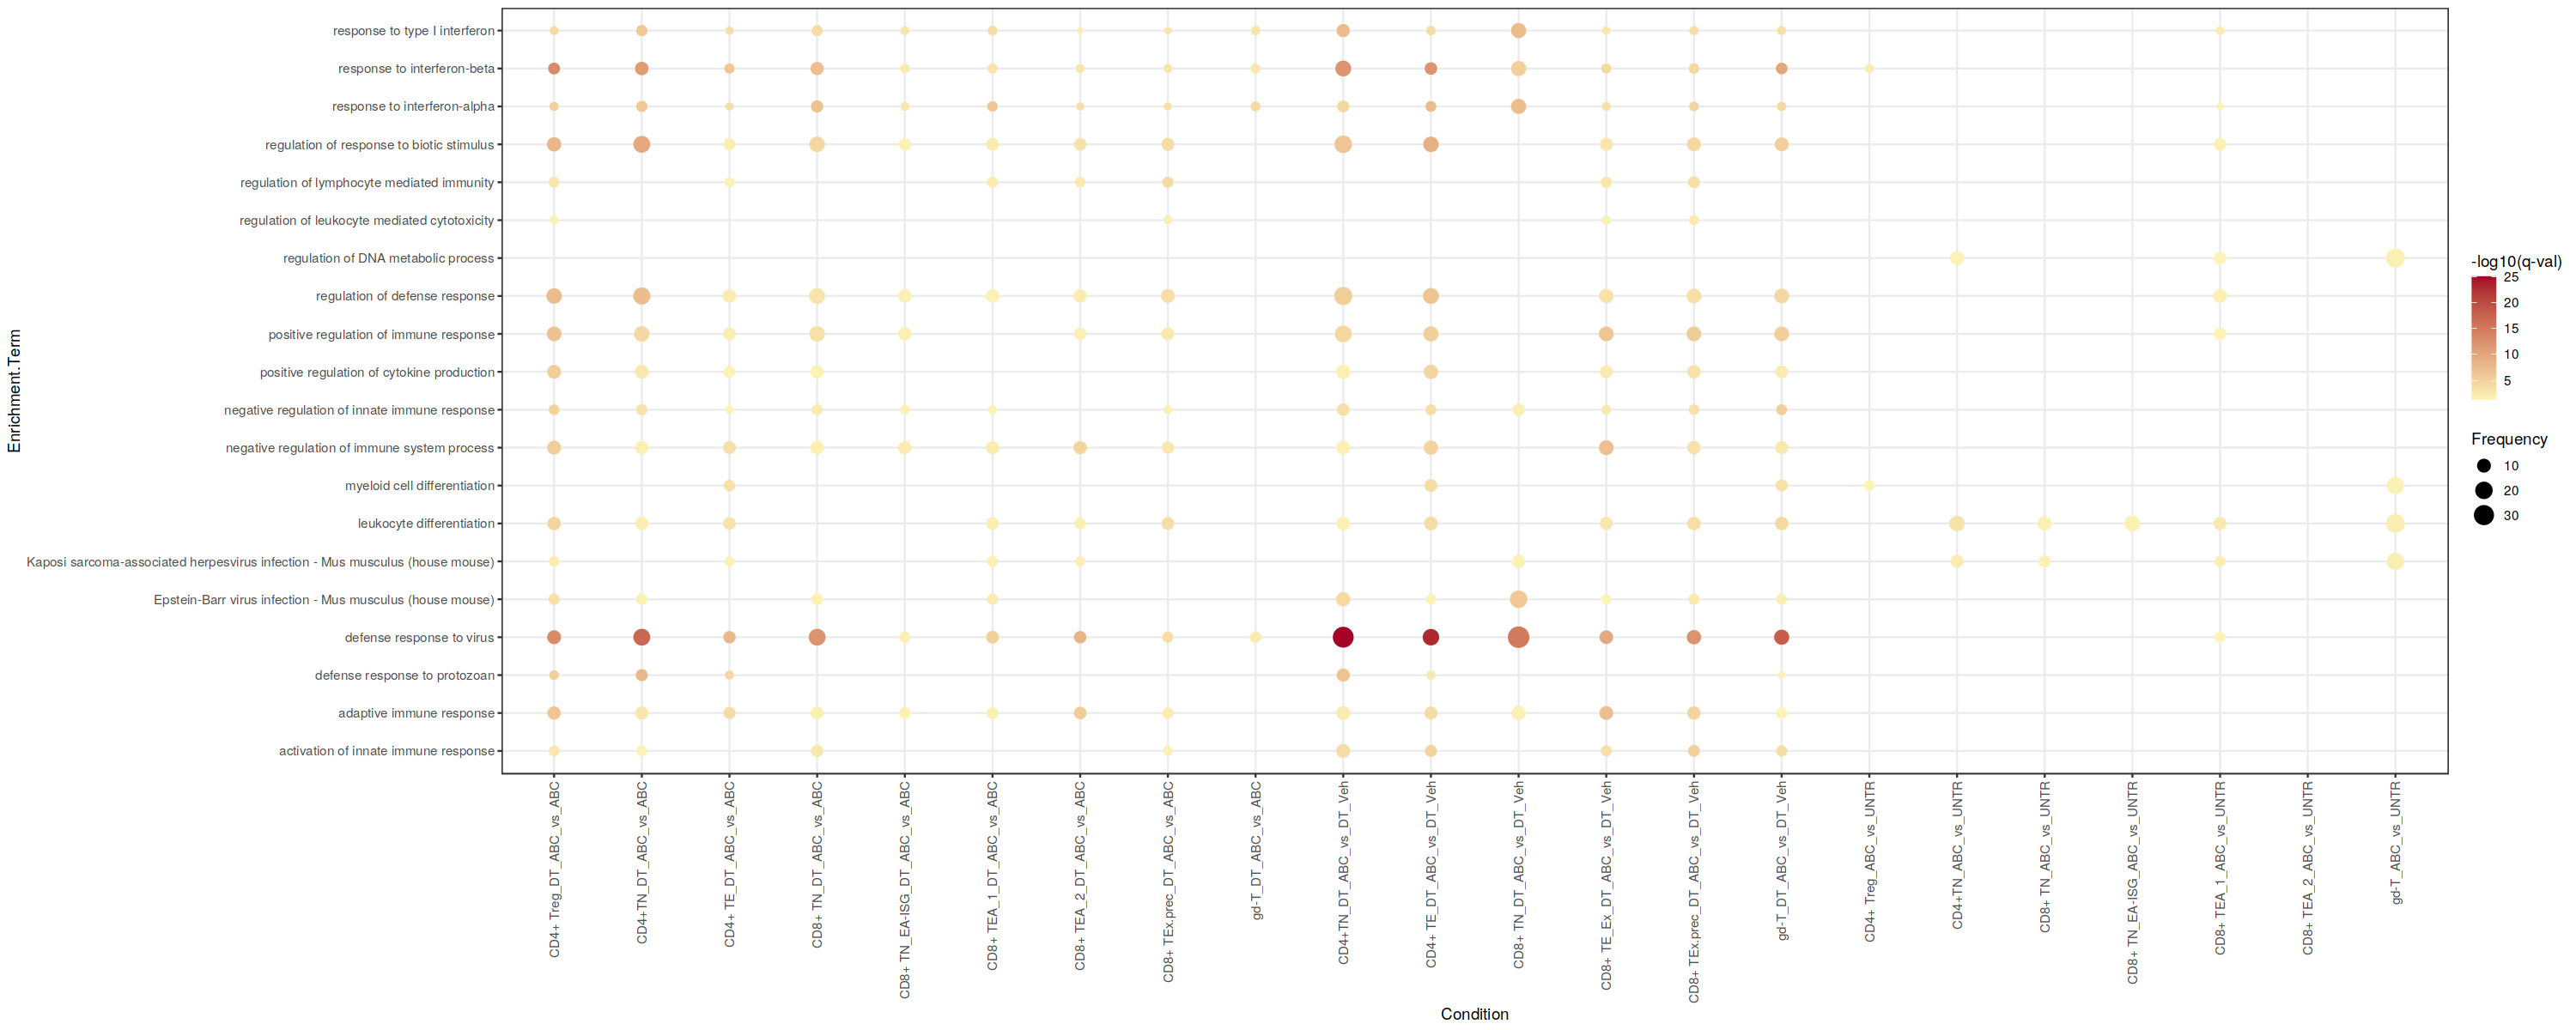

In [638]:
h_ = 10
w_ = 25
options(repr.plot.height=h_, repr.plot.width=w_)

green_hex = brewer.pal(n = 11, name ='RdYlGn')[[11]]
yellow_hex = brewer.pal(n=11, name = 'RdYlBu')[[6]]
red_hex = brewer.pal(n=11, name = 'RdYlBu')[[1]]


ggplot(data = viz.df, aes(x = Condition, y = Enrichment.Term, color = log10p, size = Frequency)) + 
geom_point() + 
scale_color_gradient2(low = green_hex, mid = yellow_hex, high = red_hex, name = '-log10(q-val)') + 
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))